### These python libraries are already installed in the VM so no need to run the next two snippets

In [ ]:
#!pip install datalab
#!pip install jupyter_contrib_nbextensions
#!jupyter nbextension install --py datalab.notebook --sys-prefix
#!pip install --upgrade oauth2client
#!pip install google-cloud-monitoring

In [10]:
#!pip install networkx

You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


---
# First IPython Block to run
--- this gives error but its ok run it. will try to fix later

In [ ]:
%load_ext google.datalab.kernel

# Import libraries 

In [32]:
import numpy as np
import pandas as pd
import time
import os, re, csv
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
import operator

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

# BQ imports
import google.datalab.bigquery as bq
%matplotlib inline

---
# Actual Python Code for Drug Annotation
### Retrieve all Drug Strings from FPM Data and Save it to a Pandas CSV file for processing via MedEx

In [9]:
%%bq query -n requests
SELECT Charge_Desc
FROM `data.All_Drugs_charge_master_pharmacy`

In [ ]:
df = requests.execute(output_options=bq.QueryOutput.dataframe()).result()

print (df.shape)
df.head()

In [11]:
def _refine(s):
    r = re.compile(r"^[^A-Za-z]+")
    a = r.sub("", s.strip()).upper()
    a = " ".join(a.split())
    return a

print (_refine("##Morphine *PF* 1mg/mL inj NICU-IV Item"))
print (_refine('"FENTANYL CIT 100MCG PA,E"'))
print (_refine("LIDOCAINE JELLY 2% 5ML URO-JET "))
print (_refine("aminophylline 25 mg/mL inj 20mL"))

MORPHINE *PF* 1MG/ML INJ NICU-IV ITEM
FENTANYL CIT 100MCG PA,E"
LIDOCAINE JELLY 2% 5ML URO-JET
AMINOPHYLLINE 25 MG/ML INJ 20ML


In [45]:
df = pd.concat([df["Charge_Desc"].apply(_refine)], axis=1)

In [51]:
df.to_csv("PharmaCodes.tsv", sep="\t", index=False, header=False, quoting=csv.QUOTE_NONE)

---

### Run MedEx on the VM 
---

--- Split the PharmaCodes file into multiple files with 1000 strings each

<font color=green>split PharmaCodes.tsv</font>

--- Run MedEx 

<font color=green>java -Xmx1024m -cp lib/*:bin org.apache.medex.Main -i [input directory] -o [output directory]</font>

---

### Retrieve and process all output files

In [52]:
def get_reqd_fileset(folder_path, exclusion_criteria=None):
    "A class of navigators on the file system"
    fileset = None
    for root, dirs, files in os.walk(folder_path):
        fileset = [x for x in files if not exclusion_criteria(x)] if exclusion_criteria else files
    return fileset

In [53]:
files = get_reqd_fileset("Medex_UIMA_1.2.1/output_refined")

In [54]:
folderName = "Medex_UIMA_1.2.1/output_refined/"
fileOutput = {}
columns = ["index", "Sentence text", "Drug name", "Brand name", "Drug form", "Strength", "Dose amount", "Route",
           "Frequency", "Duration", "Neccessity", "UMLS CUI", "RXNORM RxCUI", "RXNORM RxCUI for generic name",
           "Generic name"]

for k in files:
    df = pd.read_csv(folderName + k, sep="|", header=None)
    df = pd.concat([df[0].apply(lambda x: k + x.split("\t")[0]).to_frame(name="index"), 
                               df[0].apply(lambda x: x.split("\t")[1]).to_frame(name="drugstr"),
                    df[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]], axis=1)
    df.columns = columns
    fileOutput[k] = df

In [ ]:
fileOutput['xjx'].head(30)

### Combine and Upload to BigQuery

#### This block combines all the individual data frames generated post-Medex code execution and uploads it to the BigQuery database
#### No Need to run this block unless MedEx parameters are changed ~ would just update the BigQuery table

In [ ]:
columns = ["index", "sentence_text", "drug_name", "brand_name", "drug_form", "strength", "dose_amount", "route",
           "frequency", "duration", "neccessity", "umls_cui", "rxnorm_rxcui", "rxnorm_rxcui_generic",
           "generic_name"]

ccount = 0
for m in fileOutput:
    if ccount == 0: df = deepcopy(fileOutput[m])
    else: df = pd.concat([df, fileOutput[m]], axis=0, sort=False)
    print ("combined: ", m, "final shape: ", df.shape[0])
    ccount += 1
    #if ccount > 10: break

df = df.sort_values("index", ascending=False)
df.columns = columns
df.loc[df["rxnorm_rxcui"].isnull(), "rxnorm_rxcui"] = ""
df["rxnorm_rxcui"] = df["rxnorm_rxcui"].apply(lambda x: str(int(x)) if not type(x) is str else "")
df.loc[df["rxnorm_rxcui_generic"].isnull(), "rxnorm_rxcui_generic"] = ""
df["rxnorm_rxcui_generic"] = df["rxnorm_rxcui_generic"].apply(lambda x: str(int(x)) if not type(x) is str else "")
#print (df.head())
df.to_gbq("data.all_drugs_medex_processed_refined", "bds-opioid", chunksize=10000, verbose=True, 
                         reauth=False, if_exists='replace', private_key=None)

### Create a NetworkX Directed Graph with: 
#### --- 3 type of Nodes (CUI ID, RxCUI ID, Drug String), and 
#### --- 3 type of Edges (Cuiedge, Rxcuiedge, RxGenCuiedge)
##### (Generic RX CUI and RX CUI are bundled within RxCUI IDs since there might be drug strings that are generic) i.e. RxCUI === RxGenericCui

In [ ]:
#outputFolder = "nxfiles/" #--- was hoping I will have to save one graph file at a time --not required
#ccount = 0
G = nx.DiGraph()
for m in fileOutput:
    #print (ccount, m)
    ap = fileOutput[m].to_dict(orient="index")
    for k in ap:
        rxcui = "nan"
        G.add_node(ap[k]["index"], text=ap[k]["Sentence text"], name=ap[k]["Drug name"], ntype="drugstr")
        if str(ap[k]["UMLS CUI"]).lower() != "nan":
            G.add_node(ap[k]["UMLS CUI"], ntype="cui")
            G.add_edge(ap[k]["index"], ap[k]["UMLS CUI"], etype="cuiedge")
        if str(ap[k]["RXNORM RxCUI"]).lower() != "nan":
            try: 
                rxcui = str(int(ap[k]["RXNORM RxCUI"]))
                G.add_node(rxcui, ntype="rxcui")
                G.add_edge(ap[k]["index"], rxcui, etype="rxcuiedge")
            except: 
                # faulty MedEx extractions
                print (ap[k]["RXNORM RxCUI"], "not processed") 
        if str(ap[k]["RXNORM RxCUI for generic name"]).lower() != "nan":
            rxgencui = str(int(ap[k]["RXNORM RxCUI for generic name"]))
            G.add_node(rxgencui, name=ap[k]["Generic name"], ntype="rxcui")
            if rxcui != "nan": G.add_edge(rxcui, rxgencui, etype="rxgencuiedge")
    #print (len(G.nodes()), len(G.edges()))
    #nx.write_gpickle(G, outputFolder + m + ".gpickle")
    #ccount += 1

(393823, 746527) #unrefined

In [58]:
len(G.nodes()), len(G.edges())

(427026, 743057)

In [59]:
# Save the networkx gpickle file
nx.write_gpickle(G, "alldrugcodes_m_refined.gpickle")

### Helper functions to look at characteristics of the Directed Graph

In [45]:
aG = nx.read_gpickle("alldrugcodes_m_refined.gpickle")
len(aG.nodes()), len(aG.edges())

(427026, 743057)

In [42]:
# printer functions
def get_all_isolates():
    # These are drug strings with no CUI or RXCui
    return nx.isolates(aG)

def get_node_set(nodetype):
    node_set = []
    for n in aG.nodes():
        if aG.node[n]["ntype"] == nodetype: node_set.append(n)
    return node_set

def get_node_count(nodetype):
    ap = get_node_set(nodetype)
    return len(ap)

def get_node_edge_set(edgetype):
    ## Get all incoming nodes
    node_set = set([])
    for k in aG.edges():
        if aG[k[0]][k[1]]["etype"] == edgetype: node_set.add(k[0])
    return node_set

def _get_drug_strs1(_ui, is_cui=True):
    #OBSOLETE
    if not aG.has_node(_ui): return []
    if is_cui: return [k[0] for k in aG.in_edges(_ui)]
    else:
        _strs = [k[0] for k in aG.in_edges(_ui)]
        drstrs = []
        for k in _strs:
            if aG.node[k]["ntype"] == "drugstr": drstrs.append(k)
            else:
                _hopb = [m[0] for m in aG.in_edges(k)] 
                drstrs.extend(_hopb)
        return drstrs
    
def _get_drug_strs(_ui):
    #generic function to get drug strings given a CUI or RXCUI
    #dealing with generic RxCuis, assuming some drug strings may be linked to generic CUIs, 
    #whereas other drug strings may be linked to RxCuis, which are in turn linked to generic CUIs
    if not aG.has_node(_ui): return []
    drstrs = []
    for k in nx.ancestors(aG, _ui):
        if aG.node[k]["ntype"] == "drugstr": drstrs.append(k)
    return drstrs

In [46]:
# check how many drug strings are not matched to either a CUI or rxCUI
print (len(nx.isolates(aG)))

5380


In [47]:
# check how many drug strings exist in FPM
get_node_count("drugstr")

379588

In [6]:
# check how many RxCUI Nodes are present post-MedEx processing
get_node_count("rxcui")

27491

#### Determine how many drug strings have associated CUI codes and RX Cui codes

In [7]:
# check how many drug strings are matched to RxCUIs and CUIs
rxcuis = get_node_edge_set("rxcuiedge")
cuis = get_node_edge_set("cuiedge")

Old statistics # 268716 340270

In [8]:
print (len(cuis), len(rxcuis))

288983 374208


### Getting Opioid related Drugs

In [36]:
oG = nx.read_gpickle("opioid_drugs_wcod.gpickle")

In [37]:
len(oG.nodes()), len(oG.edges())

(10156, 13581)

In [38]:
def _get_node_set(G, node_type):
    #redundant function -- merge with previous function get_node_set ...
    node_set = []
    for m in G.nodes():
        if G.node[m]["ntype"] == node_type:
            node_set.append(m)
    return node_set

def get_cuis(G):
    cuis_all = {}
    cui_nodes = _get_node_set(G, "cui_id")
    for m in cui_nodes:
        cuis_all[m] = [a[0] for a in G.in_edges(m)]
    return cuis_all

def get_rxcuis(G):
    rxcuis_all = {}
    for m in G.nodes():
        if "rxcuis" in G.node[m]:
            rxcuis = G.node[m]["rxcuis"].split(":-:")
            for n in rxcuis:
                if not n in rxcuis_all: rxcuis_all[n] = []
                rxcuis_all[n].append(m)
    return rxcuis_all

In [39]:
cui_nodes = get_cuis(oG)
rxcui_nodes = get_rxcuis(oG)

In [40]:
len(cui_nodes), len(rxcui_nodes)

(5051, 5188)

### Look for OPIOID related drug coverage

In [48]:
for k in rxcui_nodes:
    strs = _get_drug_strs(k)
    #print (strs)
    rxcui_nodes[k] = {"ids": rxcui_nodes[k], "strs": strs, "lstrs": len(strs), 
                      "lab": "; ".join([oG.node[m]["label"] for m in rxcui_nodes[k]]), 
                      "labstrs": "; ".join([aG.node[m]["text"] for m in strs])}

In [49]:
rxcui_nodes_df = pd.DataFrame.from_dict(rxcui_nodes, orient="index")
rxcui_nodes_df = rxcui_nodes_df.sort_values("lstrs", ascending=False)
rxcui_nodes_df = rxcui_nodes_df[rxcui_nodes_df["lstrs"] > 0]
rxcui_nodes_df = rxcui_nodes_df[["ids", "lab", "labstrs", "strs", "lstrs"]]
rxcui_nodes_df = rxcui_nodes_df.reset_index()
rxcui_nodes_df.to_csv("opioid_rxcui_mappings_ref.tsv", sep="\t", index=None)
print (rxcui_nodes_df.shape)
rxcui_nodes_df.head(30)

(727, 6)


,index,ids,lab,labstrs,strs,lstrs
0,7052,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Morphine""@en",MORPHINE 10MG (10MG) INJ; MORPHINE 1MG/0.5ML S...,"[xmy789, xdi474, xnl360, xld155, xel973, xav69...",3949
1,4337,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Fentanyl""@en",FENTANYL 75 MCG/HR PATCH; SUBLIMAZE 20ML; FENT...,"[xad810, xep52, xaj283, xbj280, xio563, xbe43,...",2231
2,3423,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Hydromorphone""@en","HYDROMORPHONE INJ, 1 MG; HYDROMORPHONE 1MG/ML ...","[xdu509, xnn627, xfm976, xag511, xmd919, xhf31...",1607
3,7804,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Oxycodone""@en",OXYCODONE HCL 30MG TABLET; OXYCODONE SOLN 5MG/...,"[xll909, xeb785, xfe174, xig513, xei396, xeo55...",1353
4,203177,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Hydromorphone Hydrochloride""@en",HYDROMORPHONE HCL ER 8 MG PO TB24 8 MG; HYDROM...,"[xhf319, xnn627, xag511, xdu509, xev801, xmu56...",1051
5,82063,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Oxycodone Hydrochloride""@en",WCH OXYCODONE 5MG/5ML; OXYCODONE 40 MG SRCAP; ...,"[xob817, xip229, xcs674, xeb785, xdh220, xfe17...",978
6,5489,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Hydrocodone""@en",HYDROCODONE 7.5 MG/ACETAMINOPHEN 325 MG TABLET...,"[xdh55, xae110, xgt730, xia332, xei548, xiy760...",910
7,6754,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Meperidine""@en",DEMEROL 5 MG INJ; MEPERIDINE HCL 100 MG/ML ML;...,"[xcu627, xmo582, xha622, xia294, xhh252, xga32...",904
8,6813,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Methadone""@en",METHADONE PO SOLN 2 MG/1 ML DU; METHADONE TAB ...,"[xib515, xcj489, xgt578, xhu888, xlg281, xik99...",698
9,2670,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Codeine""@en",CODEINE SO4 TABLET 15MG UD 053218; TYLENOL & C...,"[xey164, xmk329, xjh666, xqa238, xdm897, xls14...",666


In [50]:
for k in cui_nodes:
    strs = _get_drug_strs(k)
    cui_nodes[k] = {"ids": cui_nodes[k], "strs": strs, "lstrs": len(strs), 
                    "lab": "; ".join([oG.node[m]["label"] for m in cui_nodes[k]]), 
                    "labstrs": "; ".join([aG.node[m]["text"] for m in strs])}

In [51]:
cui_nodes_df = pd.DataFrame.from_dict(cui_nodes, orient="index")
cui_nodes_df = cui_nodes_df.sort_values("lstrs", ascending=False)
cui_nodes_df = cui_nodes_df[cui_nodes_df["lstrs"] > 0]
cui_nodes_df = cui_nodes_df[["ids", "lab", "labstrs", "strs", "lstrs"]]
cui_nodes_df = cui_nodes_df.reset_index()
cui_nodes_df.to_csv("opioid_cui_mappings_ref.tsv", sep="\t", index=None)
print (cui_nodes_df.shape)
cui_nodes_df.head(30)

(554, 6)


,index,ids,lab,labstrs,strs,lstrs
0,C0015846,[<http://purl.bioontology.org/ontology/UATC/N0...,"""fentanyl""@en; ""fentanyl""@en",FENTANYL INTRATHECAL SYRINGE; FENTANYL 100MCG/...,"[xji630, xai970, xmc605, xoa951, xcw651, xpz89...",796
1,C0020264,[<http://purl.bioontology.org/ontology/UATC/R0...,"""hydrocodone""@en",HYDROCODONE 7.5 MG/ACETAMINOPHEN 325 MG TABLET...,"[xdh55, xae110, xgt730, xei548, xiy760, xib764...",617
2,C0026549,[<http://purl.bioontology.org/ontology/UATC/N0...,"""morphine""@en",MORPHINE PFS PCA 30MG/30ML; MORPHINE SULFA 50 ...,"[xew408, xom950, xdt21, xne672, xme896, xbh752...",492
3,C0012306,[<http://purl.bioontology.org/ontology/UATC/N0...,"""hydromorphone""@en",HYDROMORPHONE IN 0.9 % NACL 30 ML; HYDROMORPHO...,"[xmd919, xkz947, xgk337, xbk356, xqd582, xhr93...",269
4,C2730170,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Morphine Sulfate 10 MG""@en",MORPHINE 10MG (10MG) INJ; MORPHINE ELIX 10MG; ...,"[xmy789, xju61, xmb689, xla607, xen485, xpy615...",259
5,C2730213,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Morphine Sulfate 2 MG/ML""@en",MORPHINE SYR 2 MG/1 ML; MORPHINE 2MG/1ML CARPU...,"[xkc343, xcn812, xgb562, xdi474, xhv709, xhl82...",232
6,C2730159,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Morphine Sulfate 1 MG/ML""@en",MORPHINE 1MG/ML 50ML BXT; MORPHINE PF AMP 10 M...,"[xfh656, xpf295, xjc407, xoy872, xjf518, xit74...",197
7,C0030049,[<http://purl.bioontology.org/ontology/UATC/N0...,"""oxycodone""@en",OXYCODONE/ACET TAB 5 MG/325 MG; OXYCODONE/APAP...,"[xgj541, xcu350, xgh468, xmn968, xfl133, xec65...",196
8,C3213448,[<http://purl.bioontology.org/ontology/RXNORM/...,"""Fentanyl Injectable Product""@en",FENTANYL CITR INJ 25MCG/0.5ML; FENTANYL INJ 50...,"[xpv64, xbj314, xbv976, xbk904, xgj195, xbf835...",179
9,C0009214,[<http://purl.bioontology.org/ontology/UATC/R0...,"""codeine""@en",CODEINE-BUTALBITAL-ASA-CAFF 30-50-325-40 MG OR...,"[xjo701, xkv618, xpi966, xeu649, xho40, xdd371...",135


In [52]:
mapped_rxcui_strs = set([])
for a in list(rxcui_nodes_df["strs"]): mapped_rxcui_strs = mapped_rxcui_strs.union(set(a))
print (len(mapped_rxcui_strs))

19215


In [53]:
mapped_cui_strs = set([])
for a in list(cui_nodes_df["strs"]): mapped_cui_strs = mapped_cui_strs.union(set(a))
print (len(mapped_cui_strs))

11477


### Check the occurrence of each UMLS CUI and RxNORM RxCUI in the FPM Database

#### You can execute some query like q = lambda x: "SELECT * FROM `data.All_Drugs_charge_master_pharmacy` WHERE Charge_Desc = '" + x + "'", but repeated querying to the BigQuery table for each string does not make sense

In [7]:
%%bq query -n requests
SELECT * FROM `data.All_Drugs_charge_master_pharmacy`

In [8]:
df = requests.execute(output_options=bq.QueryOutput.dataframe()).result()
df["Charge_Desc"] = df["Charge_Desc"].apply(lambda x: x.strip())
print (df.shape)
df.head()

(425059, 2)


,Charge_Desc,Count
0,PHARM REV CODE 250,28940
1,HC PHARM REV CODE 250,24845
2,HC PHARM REV CODE 636 W HCPCS,19386
3,SOLN IV NSS 1000ML 2B1324,2814
4,.9% NACL 500ML,2105


In [9]:
df = df.set_index("Charge_Desc")
df = df.to_dict(orient="index")

In [10]:
rxcui_nodes_df = pd.read_csv("opioid_rxcui_mappings.tsv", sep="\t")
cui_nodes_df = pd.read_csv("opioid_cui_mappings.tsv", sep="\t")

In [12]:
error_strs = set([])

def _get_act_lstrs(x):
    _lst_count = []
    ap = x.split("; ")
    for k in ap: 
        if k in df: _lst_count.append(k)
    return _lst_count

def _get_oc_count(x):
    _oc_count = []
    ap = x.split("; ")
    for k in ap: 
        if k in df: _oc_count.append(df[k]["Count"])
        else: error_strs.add(k)
    return sum(_oc_count)

In [13]:
rxcui_nodes_df_c = pd.concat([rxcui_nodes_df, 
                              rxcui_nodes_df["labstrs"].apply(lambda x: _get_oc_count(x)).to_frame(name="oc_count")], 
                             axis=1)

In [14]:
cui_nodes_df_c = pd.concat([cui_nodes_df, 
                            cui_nodes_df["labstrs"].apply(lambda x: _get_oc_count(x)).to_frame(name="oc_count")], 
                            axis=1)

In [15]:
len(error_strs), list(error_strs)[0:20]

(2787,
 ['IPRATROPIUM-ALBUTEROL AE 20-100MC "NARCAN INJ, 0.4MG/ML 1ML"',
  'HYDROMORPHONE 30MG/30MLPCA/4MG 25021-0113-82 - fluconazole 200 mg/100 mL-0.9% Sol',
  'MORPHINE 0.5 MG/ML IN 1 ML 0.9% SODIUM CHLORIDE 1  00904-5058-60 - bisacodyl 10 mg Sup',
  'NALBUPHINE 10MG/1ML AMPULE "INJ, CANDIN ANTIGEN FOR TREATMENT OF WARTS, 0.3 CC" 63459-0391-20 - bendamustine 100 mg INJ',
  'FENTANYL (PF) 50 MCG/ML REPACKAGE SYRINGE "MEDROXYPROGESTERONE AC INJ, 1MG "',
  'ERYTHROMYCIN 333MG TABLET UD "HYDROMORPHONE, UP TO 4MG INJ"',
  'MEDROXYPROGESTERONE AC 1MG INJ "ACETAMINOPHEN 325MG,TABLET" duloxetine HCL 30mg Cap levothyroxine 0.15 mg Tab UD',
  'CYTOXAN 500 MG IV "INJ, OXYTOCIN 20 UNITS IN NS" ##Fentanyl 250mcg/5mL inj (for Epidurals/Intrathec',
  'B-COMPLEX WITH C- 00591-3214-72 - FENTANYL 100 MCG/HR ER FIL',
  'OPIUM TINCT PED 10/1 1ML LQ 24338-0124-13 - ERYTHROMYCIN 333 MG EC TAB',
  'OXYCODONE SR TAB 20 MG "LACTOBACILLUS ACIDOPHILUS 100,000,000 CFU GRANULES"',
  'HYDROMORPHONE HCL PCA 30 ML

In [16]:
rxcui_nodes_df_c.to_csv("opioid_rxcui_mappings_count.tsv", sep="\t", index=None)
cui_nodes_df_c.to_csv("opioid_cui_mappings_count.tsv", sep="\t", index=None)

In [17]:
rxcui_nodes_df_c = pd.read_csv("opioid_rxcui_mappings_count.tsv", sep="\t")
cui_nodes_df_c = pd.read_csv("opioid_cui_mappings_count.tsv", sep="\t")

In [36]:
cui_nodes_df_c[cui_nodes_df_c["oc_count"] > 10].shape

(351, 7)

In [97]:
plt.rcParams['figure.figsize'] = [10, 5]

def plot_scatter_dist(_df_c, ctype="CUI"):
    ylim = np.max(_df_c["oc_count"])
    xlim = np.max(_df_c["lstrs"])
    plt.scatter(_df_c["lstrs"], _df_c["oc_count"], alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Drug Strings Mapped to a " + ctype, fontsize=16)
    plt.ylabel("Total Observations for a " + ctype, fontsize=16)
    plt.ylim(1, ylim*1.5)
    plt.plot([1, xlim], [100, 100], 'k-', lw=2)
    plt.plot([1, xlim], [10, 10], 'k-', lw=2)
    plt.text(xlim*0.1, 12, ctype + "s above 10: " + str(_df_c[_df_c["oc_count"] > 10].shape[0]), fontsize=12)
    plt.text(xlim*0.1, 120, ctype + "s above 100: " + str(_df_c[_df_c["oc_count"] > 100].shape[0]), fontsize=12)
    plt.show()

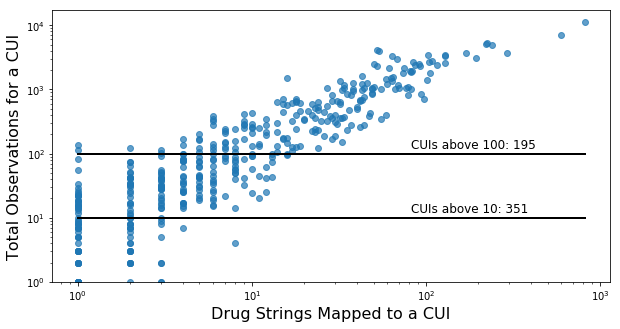

In [98]:
plot_scatter_dist(cui_nodes_df_c)

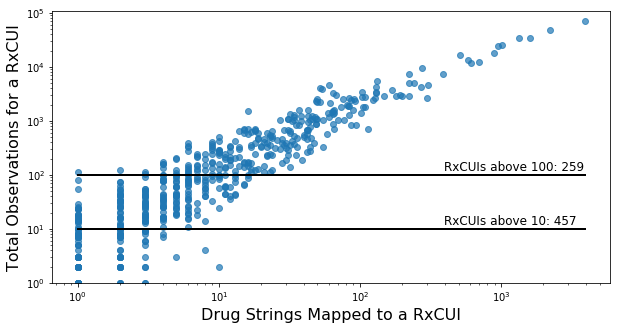

In [99]:
plot_scatter_dist(rxcui_nodes_df_c, "RxCUI")

In [102]:
cui_nodes_df_c.head(30)

,index,ids,lab,labstrs,strs,lstrs,oc_count
0,C0015846,['<http://purl.bioontology.org/ontology/UATC/N...,"""fentanyl""@en; ""fentanyl""@en",FENTANYL VL 50MCG/ML 50ML (.5; FENTANYL 2500MC...,"['xoc415', 'xdy821', 'xnr188', 'xcb318', 'xef9...",816,11418
1,C0026549,['<http://purl.bioontology.org/ontology/UATC/N...,"""morphine""@en",MORPHINE INJ 10MG/ML VIAL vancomycin 1250mg pr...,"['xne475', 'xjy873', 'xel896', 'xbt178', 'xdv2...",597,6957
2,C0012306,['<http://purl.bioontology.org/ontology/UATC/N...,"""hydromorphone""@en",HYDROMORPHONE INTRTHEC CHG; HYDROMORPHONE IT P...,"['xjf606', 'xdc709', 'xgg869', 'xnn815', 'xnv6...",292,3663
3,C2730170,['<http://purl.bioontology.org/ontology/RXNORM...,"""Morphine Sulfate 10 MG""@en","TESSALON ""INJ, MORPHINE SULFATE, UP TO 10 MG"";...","['xep3', 'xcg467', 'xpy550', 'xmf41', 'xho193'...",240,4978
4,C0030049,['<http://purl.bioontology.org/ontology/UATC/N...,"""oxycodone""@en","OXYCODONE-ASA TAB; OXYCODONE tab 5mg ""KENALOG ...","['xon175', 'xmq599', 'xlr667', 'xnr162', 'xnu1...",225,5215
5,C2730213,['<http://purl.bioontology.org/ontology/RXNORM...,"""Morphine Sulfate 2 MG/ML""@en",RCH SCREN-MORPHINE 2MG/ML 1ML CARP; MORPHINE 1...,"['xhr626', 'xao867', 'xkn419', 'xki244', 'xjh5...",221,5096
6,C2730159,['<http://purl.bioontology.org/ontology/RXNORM...,"""Morphine Sulfate 1 MG/ML""@en",PHA-MORPHINE PF 10MG/10ML; MORPHINE 1MG POWDER...,"['xko485', 'xat201', 'xjy630', 'xeq130', 'xhq4...",193,3077
7,C3213448,['<http://purl.bioontology.org/ontology/RXNORM...,"""Fentanyl Injectable Product""@en","DANTROLENE 20MG INJ VIAL ""##Fentanyl 1,200mcg ...","['xmh670', 'xeb678', 'xmo743', 'xcb360', 'xga6...",169,3737
8,C1125132,['<http://purl.bioontology.org/ontology/RXNORM...,"""Fentanyl 0.1 MG""@en",FENTANYL CITRATE 0.1MG INJ; FENTANYL (PER 0.1M...,"['xaa420', 'xed413', 'xdx71', 'xoa708', 'xpz55...",129,3394
9,C1123147,['<http://purl.bioontology.org/ontology/RXNORM...,"""Fentanyl 0.05 MG/ML""@en",FENTANYL 0.05MG/ML AMPUL; FENTANYL (PF) 50 MCG...,"['xir841', 'xka644', 'xjq571', 'xeh689', 'xjf6...",129,3313


In [101]:
rxcui_nodes_df_c.head(10)

,index,ids,lab,labstrs,strs,lstrs,oc_count
0,7052,['<http://purl.bioontology.org/ontology/RXNORM...,"""Morphine""@en",AVODART 0.5MG TABLET morphine 20 mg/mL conc 30...,"['xcz755', 'xhh69', 'xds349', 'xga705', 'xgf68...",3918,71557
1,4337,['<http://purl.bioontology.org/ontology/RXNORM...,"""Fentanyl""@en",FENTANYL 0.05MG/ML AMPUL; FENTANYL 1 MG/NACL 0...,"['xir841', 'xcb318', 'xaq326', 'xhw770', 'xpv5...",2224,48134
2,3423,['<http://purl.bioontology.org/ontology/RXNORM...,"""Hydromorphone""@en",HYDROMORPHONE HP 10MG=1ML; HYDROMORPHONE HCL 1...,"['xlv322', 'xob669', 'xhg377', 'xja838', 'xax6...",1598,33927
3,7804,['<http://purl.bioontology.org/ontology/RXNORM...,"""Oxycodone""@en","OXYCODONE tab 5mg ""KENALOG -40 VL 1ML... ,,"";...","['xmq599', 'xnu118', 'xnd614', 'xnv260', 'xka8...",1343,33763
4,203177,['<http://purl.bioontology.org/ontology/RXNORM...,"""Hydromorphone Hydrochloride""@en",HYDROMORPHONE HP 10MG=1ML; HYDROMORPHONE HCL 1...,"['xlv322', 'xob669', 'xpy631', 'xhg377', 'xja8...",1024,24999
5,82063,['<http://purl.bioontology.org/ontology/RXNORM...,"""Oxycodone Hydrochloride""@en",OXYCODONE 20MG TAB(S.R.); OXYCODONE HCL TAB 5M...,"['xcf298', 'xbo310', 'xid402', 'xej153', 'xnd6...",949,23883
6,6754,['<http://purl.bioontology.org/ontology/RXNORM...,"""Meperidine""@en",MEPERIDINE HCL 100MG; MEPERIDINE 50MG/1ML INJ;...,"['xhz915', 'xbp303', 'xoa767', 'xmi644', 'xph3...",895,18378
7,6813,['<http://purl.bioontology.org/ontology/RXNORM...,"""Methadone""@en",METHADONE HCL HEONATAL CON 0.5MG/ML; METHADONE...,"['xlk27', 'xoy36', 'xjk698', 'xni836', 'xhc313...",695,12164
8,7242,['<http://purl.bioontology.org/ontology/RXNORM...,"""Naloxone""@en",IV FAT EMULSION 10% ##Naloxone 0.4mg/mL inj (...,"['xoc898', 'xjt402', 'xnf343', 'xkz504', 'xhh9...",617,11912
9,142436,['<http://purl.bioontology.org/ontology/RXNORM...,"""Fentanyl Citrate""@en",FENTANYL 0.05MG/ML AMPUL; FENTANYL *R* INJ 50 ...,"['xir841', 'xoe485', 'xfo167', 'xcn149', 'xog3...",579,13334


#### --------------------------------
#### Reading the NetworkX gpickle file with Drug Strings and CUI/RxCUI nodes (FPM Drug Network)
#### Adding Charge IDs to the different Drug Strings
#### --------------------------------

In [14]:
aG = nx.read_gpickle("alldrugcodes_m_refined.gpickle")

In [24]:
unmatched_charges = set([])
drug_strs_with_charge = set(df["Charge_Desc"])
drug_strs_in_network = set([])
for k in aG.nodes():
    if aG.node[k]['ntype'] == "drugstr": drug_strs_in_network.add(aG.node[k]["text"])

In [25]:
# Drug strings with ChargeId, but not in network -- this is weird -- difference of ~ 50000 :/
len(drug_strs_in_network), len(drug_strs_with_charge)

(345997, 390931)

In [27]:
unmatched_charges = drug_strs_in_network - drug_strs_with_charge
print (len(unmatched_charges)) #Drug Strings in network without associated charge id

1234


In [49]:
adf = df[["Charge_ID", "Charge_Desc"]]

In [34]:
adf = adf[0:50000]

In [50]:
def _comb(dfa):
    return set(dfa["Charge_ID"])
    
adf = adf.groupby("Charge_Desc").apply(_comb)
print (adf.head())

Charge_Desc
                            {9087873, 5269892, 182021, 9077764, 26413449, ...
A & D 45GM TP                                                       {7333321}
A & D OINT                                                          {5551720}
A & D OINT 1-1/2 OZ TUBE               {427385, 27316301, 29990637, 23189263}
A & D OINT 2 OZ                                          {12116729, 22494460}
dtype: object


In [60]:
unmatched_charges_2 = set([])
for k in aG.nodes():
    if aG.node[k]['ntype'] == "drugstr": 
        if aG.node[k]["text"] in adf: ids = adf[aG.node[k]["text"]]
        else: 
            unmatched_charges_2.add(aG.node[k]["text"])
            ids = set([])
        aG.node[k]["charge_ids"] = ids

In [61]:
print (len(unmatched_charges_2))

1234


In [62]:
nx.write_gpickle(aG, "all_drug_nodes_with_charge_id.gpickle")

In [64]:
for k in aG.nodes()[0:10]:
    print (k, aG.node[k])

xai508 {'text': 'BRIMONIDINE 0.2 % EYE DROPS 5 ML', 'name': 'BRIMONIDINE[13577,13588]', 'ntype': 'drugstr', 'charge_ids': {28629249, 29384848, 21607447, 21767322, 29361691, 29280926, 29475110, 29917746, 21575219, 29419955, 30287029, 26195250, 29580280, 6144825, 29771070, 29842497, 30118721, 23991116, 29816666, 25780187, 1296991, 11380320, 26147941, 29996517, 26137704, 24614890, 29259115, 29534188, 29534189, 26616171, 26500074, 26265072, 935540, 29378295, 30154872, 26139257, 8733051, 23006718, 30888447}}
xkc357 {'text': 'TETRACYCLINE CAP 500', 'name': 'TETRACYCLINE[9603,9615]', 'ntype': 'drugstr', 'charge_ids': {1960072, 1960073, 5436806}}
xao722 {'text': 'FLUTICASONE 16G NASAL', 'name': 'FLUTICASONE[19426,19437]', 'ntype': 'drugstr', 'charge_ids': {22258210, 12579236, 22463214, 4773135, 321518, 6565586, 22436595, 21604788, 11364127, 22725942, 22470527, 10566492, 5744158, 23050015}}
xgj955 {'text': 'RILPIVIRINE 25MG TABLET', 'name': 'RILPIVIRINE[25471,25482]', 'ntype': 'drugstr', 'charg

#### --------------------------------
#### Abstract each RxCUI/CUI to an Opioid Generic Drug
#### --------------------------------

In [59]:
aG = nx.read_gpickle("all_drug_nodes_with_charge_id.gpickle")

In [54]:
#file generated in the Static drug network ipython notebook
#@TODO: Update with new Rxnorm Mapper file since this one does not have "Codeine" Generic Drug in it!
rxnorm_mapper = pd.read_csv("rxnorm_mapper_wcod.tsv", sep="\t")
rxnorm_mapper.head(48)

,index,cui_nodes,rxcui_nodes,label
0,10597,"set(['C0282365', 'C2928823'])","set(['105183', '1007909', '1293456', '168479',...","""Tilidine""@en"
1,10689,"set(['C0787304', 'C3206743', 'C3206742', 'C131...","set(['', '1293451', '835604', '835605', '83560...","""Tramadol""@en"
2,135095,"set(['C0982958', 'C0792388', 'C0688399', 'C071...","set(['', '996991', '315266', '996994', '993780...","""Aspirin / Codeine""@en"
3,1545902,"set(['C2344804', 'C2954940', 'C4294579', 'C071...","set(['1545909', '1545903', '1545902', '1545907...","""Naloxone / Oxycodone""@en"
4,1551777,"set(['C3859650', 'C3857236', 'C3858216', 'C385...","set(['1551777', '1601372', '1551779', '1551780...","""naloxegol""@en"
5,17933,set(['C0770427']),"set(['235413', '17933'])","""anileridine""@en"
6,1806700,"set(['C2344804', 'C2954940', 'C4294578', 'C429...","set(['1545909', '1860151', '1545903', '1545907...","""Naltrexone / Oxycodone""@en"
7,1819,"set(['C3834489', 'C3467613', 'C3709966', 'C365...","set(['1544849', '1010608', '353391', '353390',...","""Buprenorphine""@en"
8,1841,"set(['C4073610', 'C4048621', 'C1248690', 'C381...","set(['1489987', '83373', '1809203', '371174', ...","""Butorphanol""@en"
9,22713,"set(['C1245817', 'C3212717', 'C0777940', 'C098...","set(['1098651', '315791', '315793', '315792', ...","""dezocine""@en"


In [55]:
rxnorm_mapper = rxnorm_mapper.set_index("index")
rxnorm_mapper = rxnorm_mapper.to_dict(orient="index")

In [ ]:
#the following combinations are included --- 
#"Acetaminophen / Codeine"@en - 817579
#"Codeine / Ibuprofen"@en - 710303
#"Ibuprofen / Oxycodone"@en - 484259
#"Acetaminophen / Tramadol"@en - 352362
#"Naltrexone / Oxycodone"@en - 1806700
#"Naloxone / Oxycodone"@en - 1545902
#"Aspirin / Codeine"@en - 135095

In [60]:
charge_mapper = {}
for n in aG.nodes():
    if aG.node[n]["ntype"] == "drugstr":
        rxCuis = [k for k in aG[n] if aG[n][k]["etype"] == "rxcuiedge"]
        cuis = [k for k in aG[n] if aG[n][k]["etype"] == "cuiedge"]
        for a in aG.node[n]["charge_ids"]:
            charge_mapper[a] = {"rxcuis": rxCuis, "cuis": cuis}

In [61]:
print (len(charge_mapper))

1564811


In [62]:
for k in list(charge_mapper.keys())[0:10]:
    print (k, charge_mapper[k])

25165824 {'rxcuis': ['228396'], 'cuis': ['C0753357']}
8388612 {'rxcuis': [], 'cuis': []}
25165840 {'rxcuis': ['1313111'], 'cuis': []}
25165852 {'rxcuis': ['8691'], 'cuis': ['C0033148']}
35 {'rxcuis': ['1049615'], 'cuis': []}
8388651 {'rxcuis': ['328682'], 'cuis': ['C1123644']}
8388652 {'rxcuis': ['328682'], 'cuis': ['C1123644']}
14106131 {'rxcuis': ['358819'], 'cuis': ['C1176960']}
49 {'rxcuis': ['197604'], 'cuis': []}
25165874 {'rxcuis': ['6902', '707702'], 'cuis': ['C0025815']}


#### --------------------------------
#### Generating and Saving two Big Query tables that map Charge Ids to CUI Ids and Charge IDS to RxCUI Ids
#### This is done for future use
#### --------------------------------

In [63]:
cid_rxcui = {}
cid_cui = {}
ccount1 = 0
ccount2 = 0
for k in charge_mapper:
    for m in charge_mapper[k]["rxcuis"]:
        cid_rxcui[ccount1] = {"cid": k, "rxcui": m}
        ccount1 += 1
    for m in charge_mapper[k]["cuis"]:
        cid_cui[ccount2] = {"cid": k, "cui": m}
        ccount2 += 1
cid_rxcui_df = pd.DataFrame.from_dict(cid_rxcui, orient="index")
cid_cui_df = pd.DataFrame.from_dict(cid_cui, orient="index")

In [64]:
cid_rxcui_df.shape, cid_cui_df.shape

((1680032, 2), (1246547, 2))

In [105]:
cid_rxcui_df.to_gbq("data.charge_id_to_rxcui", "bds-opioid", chunksize=10000, verbose=True, 
                         reauth=False, if_exists='replace', private_key=None)

/home/maulikrk/anaconda3/lib/python3.5/site-packages/pandas_gbq/gbq.py:969: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  stacklevel=1,
169it [10:32,  3.95s/it]


In [106]:
cid_cui_df.to_gbq("data.charge_id_to_cui", "bds-opioid", chunksize=10000, verbose=True, 
                         reauth=False, if_exists='replace', private_key=None)

125it [07:45,  3.82s/it]


#### --------------------------------
#### Normalize Charge IDs to one of the ~40 Generic RxCUIs
#### --------------------------------

In [65]:
rxcui_reverse_lookup = {}
cui_reverse_lookup = {}
for k in rxnorm_mapper:
    cui_nodes = eval(rxnorm_mapper[k]["cui_nodes"])
    rxcui_nodes = eval(rxnorm_mapper[k]["rxcui_nodes"])
    for m in cui_nodes:
        if not m in cui_reverse_lookup: cui_reverse_lookup[m] = []
        cui_reverse_lookup[m].append(k)
    for m in rxcui_nodes:
        if not m in rxcui_reverse_lookup: rxcui_reverse_lookup[m] = []
        rxcui_reverse_lookup[m].append(k)
print (len(cui_reverse_lookup))
print (len(rxcui_reverse_lookup))

4956
5188


In [66]:
charge_generic_mapper = {}
for k in charge_mapper:
    charge_generic_mapper[k] = set([])
    for m in charge_mapper[k]["rxcuis"]: 
        if m in rxcui_reverse_lookup: 
            charge_generic_mapper[k] = charge_generic_mapper[k].union(set(rxcui_reverse_lookup[m]))
    for m in charge_mapper[k]["cuis"]:
        if m in cui_reverse_lookup:
            charge_generic_mapper[k] = charge_generic_mapper[k].union(set(cui_reverse_lookup[m]))

In [67]:
#remove those charge ids with no Opioid-related generic RxCUIs
for k in list(charge_generic_mapper.keys()):
    if len(charge_generic_mapper[k]) == 0: del charge_generic_mapper[k]

In [68]:
print (len(charge_generic_mapper))

54737


In [69]:
for k in list(charge_generic_mapper.keys())[0:10]:
    print (k, charge_generic_mapper[k])

35 {7804}
25166019 {4337}
9087695 {10689}
766 {4337}
767 {4337}
25166654 {7804}
4748626 {8001}
25166977 {7052}
1295 {7052}
29361506 {7052}


In [70]:
# group Charge IDs according to Generic CUIs ... maybe more efficient for querying
# Not sure if I did this before
generic_cuis = {}
for m in charge_generic_mapper:
    for k in charge_generic_mapper[m]:
        if k not in generic_cuis: generic_cuis[k] = set([])
    generic_cuis[k].add(m)

In [71]:
ap = sorted({k: len(generic_cuis[k]) for k in generic_cuis}.items(), reverse=True, key=operator.itemgetter(1))

In [72]:
xvals = []
yvals = []
for k in ap:
    xvals.append(rxnorm_mapper[k[0]]["label"][1:-4])
    yvals.append(k[1])

In [81]:
_mcount = pd.concat([pd.Series(xvals), pd.Series(yvals)], axis=1)
_mcount = _mcount[_mcount[1] > 9]
_mcount.to_csv("_mcount.tsv", sep="\t", index=None)
_mcount.head()

,0,1
0,Morphine,9706
1,Fentanyl,6721
2,Hydromorphone,6252
3,Oxycodone,4111
4,Hydrocodone,4000


In [83]:
_mcount.shape

(35, 2)

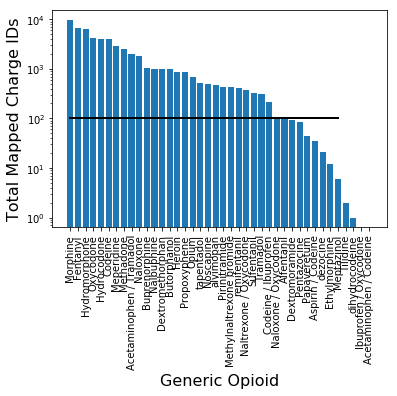

In [73]:
plt.bar(xvals, yvals)
plt.plot(0, 10)
plt.xticks(rotation=90)
plt.yscale("Log")
plt.xlabel("Generic Opioid", fontsize=16)
plt.ylabel("Total Mapped Charge IDs", fontsize=16)
plt.plot([0, 35], [100, 100], 'k-', lw=2)
plt.show()

#### --------------------------------
#### Generate Generic RxCUI x Zip Code Space Matrix 
#### --------------------------------

In [27]:
def _generate_space_matrix(gen_rxcui):
    drug = re.sub(r'\W+', '-', rxnorm_mapper[gen_rxcui]["label"][1:-4])
    print ("generating zip codes for", drug)
    q = "SELECT Zip_code FROM `data.rxcui_zip` WHERE rxcui IN (" + ",".join(["'" + str(k) + "'" for k in list(eval(rxnorm_mapper[gen_rxcui]["rxcui_nodes"]))]) + ")"
    df = bq.Query(q).execute().result().to_dataframe()
    print ("retrieved zips:", df.shape[0])
    if df.shape[0] == 0: return None
    _adf = df.groupby("Zip_code").size().reset_index()
    _adf.columns = ["Zip_code", "number_occurrences"]
    _adf.to_csv("_zip_list/" + drug + ".tsv", sep="\t", index=None)

In [28]:
for k in rxnorm_mapper:
    print (k, rxnorm_mapper[k]["label"][1:-4])
    _generate_space_matrix(k)

10689 Tramadol
generating zip codes for Tramadol
retrieved zips: 4722210
7804 Oxycodone
generating zip codes for Oxycodone
retrieved zips: 11284462
7238 Nalbuphine
generating zip codes for Nalbuphine
retrieved zips: 395395
8001 Pentazocine
generating zip codes for Pentazocine
retrieved zips: 6874
73032 remifentanil
generating zip codes for remifentanil
retrieved zips: 106224
7242 Naloxone
generating zip codes for Naloxone
retrieved zips: 1208237
8119 Phenazocine
generating zip codes for Phenazocine
retrieved zips: 0
7052 Morphine
generating zip codes for Morphine
retrieved zips: 11749731
17933 anileridine
generating zip codes for anileridine
retrieved zips: 0
979111 Methylnaltrexone bromide
generating zip codes for Methylnaltrexone-bromide
retrieved zips: 47485
8143 Phenoperidine
generating zip codes for Phenoperidine
retrieved zips: 0
8785 Propoxyphene
generating zip codes for Propoxyphene
retrieved zips: 196458
8354 Pirinitramide
generating zip codes for Pirinitramide
retrieved zips:

ValueError: Length of passed values is 14, index implies 0

#### View Zip Code Matrix

In [3]:
# There is another zip codes flat file, which has latitude/longitude, but it has 5 digit zip codes!
zip_codes = pd.read_csv("zip_codes.tsv", sep="\t", header=None)
zip_code_lookup = zip_codes.set_index(0).to_dict(orient="index")
zip_codes.head()

,0,1
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,"mid-island, NY"


In [35]:
zip_code_lookup[452]

{1: 'Cincinnati, OH'}

In [2]:
zip_locator = lambda x: zip_code_lookup[x][1] if x in zip_code_lookup else None

def _view_drug_conc(drug_name):
    drug_zips = pd.read_csv("_zip_list/" + drug_name + ".tsv", sep="\t")
    drug_zips = pd.concat([drug_zips, drug_zips["Zip_code"].apply(zip_locator).to_frame(name="region_name")], axis=1)
    drug_zips = drug_zips.sort_values("number_occurrences", ascending=False)
    return drug_zips

In [7]:
_zips = _view_drug_conc("Morphine")

In [8]:
_zips.head(30)

,Zip_code,number_occurrences,region_name
640,727,99275,north-western AR
537,606,75975,"Chicago, IL"
61,70,71181,"Newark, NJ"
62,71,64435,"Newark, NJ"
78,87,58342,"Monmouth, NJ"
132,152,54781,"Pittsburgh, PA"
250,277,50908,"Durham, NC"
248,275,50601,"Raleigh, NC"
652,741,46226,"Tulsa, OK"
651,740,41110,"Tulsa, OK"


#### --------------------------------
#### Generate Generic RxCUI x Year Time Matrix (2000 - 2015)
#### --------------------------------

In [65]:
def _generate_month_matrix(gen_rxcui):
    drug = re.sub(r'\W+', '-', rxnorm_mapper[gen_rxcui]["label"][1:-4])
    print ("generating admit months", drug)
    q = "SELECT Admit_month FROM `data.rxcui_year` WHERE rxcui IN (" + ",".join(["'" + str(k) + "'" for k in list(eval(rxnorm_mapper[gen_rxcui]["rxcui_nodes"]))]) + ")"
    df = bq.Query(q).execute().result().to_dataframe()
    print ("retrieved admit months:", df.shape[0])
    if df.shape[0] == 0: return None
    _adf = df.groupby("Admit_month").size().reset_index()
    _adf.columns = ["Admit_month", "number_occurrences"]
    _adf.to_csv("_admit_month/" + drug + ".tsv", sep="\t", index=None)
    
def _generate_year_matrix(gen_rxcui):
    drug = re.sub(r'\W+', '-', rxnorm_mapper[gen_rxcui]["label"][1:-4])
    print ("generating admit years", drug)
    q = "SELECT Admit_month FROM `data.rxcui_year` WHERE rxcui IN (" + ",".join(["'" + str(k) + "'" for k in list(eval(rxnorm_mapper[gen_rxcui]["rxcui_nodes"]))]) + ")"
    df = bq.Query(q).execute().result().to_dataframe()
    print ("retrieved admit months:", df.shape[0])
    if df.shape[0] == 0: return None
    df = pd.concat([df["Admit_month"].apply(lambda x: str(x)[0:4]).to_frame(name='Admit_year'), df], axis=1)
    del df["Admit_month"]
    _adf = df.groupby("Admit_year").size().reset_index()
    _adf.columns = ["Admit_year", "number_occurrences"]
    _adf.to_csv("_admit_year/" + drug + ".tsv", sep="\t", index=None)

In [59]:
_generate_month_matrix(56795)

generating admit months Sufentanil
retrieved admit months: 52134


In [ ]:
_generate_year_matrix(7052)

generating admit years Morphine


In [4]:
def _view_drug_conc_time(drug_name):
    drug_m = pd.read_csv("_admit_year/" + drug_name + ".tsv", sep="\t")
    drug_m = drug_m.sort_values("Admit_year", ascending=False)
    return drug_m

In [5]:
_drug_m = _view_drug_conc_time("Sufentanil")
_drug_m.head(30)

,Admit_year,number_occurrences
8,2016,3670
7,2015,4048
6,2014,5270
5,2013,7365
4,2012,7772
3,2011,11953
2,2010,9413
1,2009,2597
0,2008,46


In [38]:
### Generate Space Time matrix
def _generate_space_time_matrix(gen_rxcui):
    drug = re.sub(r'\W+', '-', rxnorm_mapper[gen_rxcui]["label"][1:-4])
    print ("generating zip codes for", drug)
    q = "SELECT Zip_code, Admit_year FROM `data.rxcui_zip_year` WHERE rxcui IN (" + ",".join(["'" + str(k) + "'" for k in list(eval(rxnorm_mapper[gen_rxcui]["rxcui_nodes"]))]) + ")"
    df = bq.Query(q).execute().result().to_dataframe()
    print ("retrieved zips:", df.shape[0])
    if df.shape[0] == 0: return None
    _adf = df.groupby(["Zip_code", "Admit_year"]).size().reset_index()
    #print (_adf.head(30), _adf.shape)
    _adf.columns = ["Zip_code", "Admit_year", "number_occurrences"]
    _adf.to_csv("_year_zip/" + drug + ".tsv", sep="\t", index=None)

In [39]:
_generate_space_time_matrix(56795)

generating zip codes for Sufentanil
retrieved zips: 52134


In [40]:
def _view_drug_conc_zip_time(drug_name):
    drug_m = pd.read_csv("_year_zip/" + drug_name + ".tsv", sep="\t")
    drug_m = drug_m.sort_values("number_occurrences", ascending=False)
    return drug_m

In [41]:
_drug_m = _view_drug_conc_zip_time("Sufentanil")
_drug_m.head(30)

,Zip_code,Admit_year,number_occurrences
58,80,2012,166
155,260,2012,145
188,278,2009,125
326,452,2009,107
441,606,2011,101
299,439,2012,100
440,606,2010,99
16,15,2009,82
442,606,2012,74
439,606,2009,71


In [42]:
for k in rxnorm_mapper:
    print (k, rxnorm_mapper[k]["label"][1:-4])
    try: _generate_space_time_matrix(k)
    except: print ("Error found for ", k)

10689 Tramadol
generating zip codes for Tramadol
retrieved zips: 4722210
7804 Oxycodone
generating zip codes for Oxycodone
retrieved zips: 11284462
7238 Nalbuphine
generating zip codes for Nalbuphine
retrieved zips: 395395
8001 Pentazocine
generating zip codes for Pentazocine
retrieved zips: 6874
73032 remifentanil
generating zip codes for remifentanil
retrieved zips: 106224
7242 Naloxone
generating zip codes for Naloxone
retrieved zips: 1208237
8119 Phenazocine
generating zip codes for Phenazocine
retrieved zips: 0
7052 Morphine
generating zip codes for Morphine
retrieved zips: 11749731
17933 anileridine
generating zip codes for anileridine
retrieved zips: 0
979111 Methylnaltrexone bromide
generating zip codes for Methylnaltrexone-bromide
retrieved zips: 47485
8143 Phenoperidine
generating zip codes for Phenoperidine
retrieved zips: 0
8785 Propoxyphene
generating zip codes for Propoxyphene
retrieved zips: 196458
8354 Pirinitramide
generating zip codes for Pirinitramide
retrieved zips:

In [45]:
def get_reqd_fileset(folder_path, exclusion_criteria=None):
    "A class of navigators on the file system"
    fileset = None
    for root, dirs, files in os.walk(folder_path):
        fileset = [x for x in files if not exclusion_criteria(x)] if exclusion_criteria else files
    return fileset

In [56]:
drug_files = get_reqd_fileset("_year_zip", lambda x: False if ".tsv" in x else True)
comb = None
ccount = 0
for m in drug_files:
    drug_m = pd.read_csv("_year_zip/" + m, sep="\t")
    drug_name = m.split(".")[0]
    drug_m = pd.concat([drug_m, pd.Series([drug_name for k in range(drug_m.shape[0])]).to_frame(name="opioid")], axis=1)
    if ccount == 0: comb = drug_m
    else:
        comb = pd.concat([comb, drug_m], axis=0)
        comb = comb.reset_index()
        del comb["index"]
    ccount += 1
    print (comb.shape)

(15, 4)
(908, 4)
(3863, 4)
(8554, 4)
(9452, 4)
(15169, 4)
(15195, 4)
(15721, 4)
(17218, 4)
(20243, 4)
(21527, 4)
(26912, 4)
(26945, 4)
(27458, 4)
(27936, 4)
(28012, 4)
(28452, 4)
(30397, 4)
(32927, 4)
(37509, 4)
(40387, 4)
(41885, 4)
(43685, 4)
(45895, 4)
(46665, 4)
(47092, 4)
(52556, 4)
(52664, 4)
(57299, 4)
(59708, 4)
(62371, 4)
(63304, 4)


In [60]:
comb = comb[["Zip_code", "Admit_year", "opioid", "number_occurrences"]]
comb.head()

,Zip_code,Admit_year,opioid,number_occurrences
0,201,2012,dezocine,1
1,226,2014,dezocine,4
2,236,2011,dezocine,2
3,277,2009,dezocine,3
4,277,2010,dezocine,1


In [61]:
comb.to_csv("combined_opioid.tsv", sep="\t", index=None)

In [1]:
import pandas as pd
comb = pd.read_csv("combined_opioid.tsv", sep="\t")

In [6]:
ap = comb[["Zip_code", "opioid", "number_occurrences"]].groupby(["Zip_code", "opioid"]).sum()

In [9]:
ap = ap.reset_index()

In [13]:
ap = ap.sort_values("number_occurrences", ascending=False)

In [19]:
import numpy as np
ap = pd.concat([ap, np.log10(ap["number_occurrences"]).to_frame(name="logn")], axis=1)

In [16]:
ap.to_csv("zip_code_count.tsv", sep="\t", index=None)

In [20]:
ap.head()

,Zip_code,opioid,number_occurrences,logn
2090,152,Fentanyl,143252,5.156101
7641,452,Oxycodone,133084,5.124126
940,71,Oxycodone,132565,5.122429
914,70,Oxycodone,124923,5.096642
1139,80,Fentanyl,124281,5.094405


In [22]:
comb1 = comb[comb["opioid"].apply(lambda x: True if x in ["Fentanyl", "Morphine", "Oxycodone"] else False)]
comb1 = comb1[comb1["Admit_year"].apply(lambda x: True if x > 2008 and x < 2016 else False)]
comb1 = pd.concat([comb1, comb1["Zip_code"].apply(zip_locator).to_frame(name="region_name")], axis=1)

In [23]:
comb1.sort_values("number_occurrences", ascending=False)

,Zip_code,Admit_year,opioid,number_occurrences,region_name
55284,452,2011,Oxycodone,38836,"Cincinnati, OH"
55283,452,2010,Oxycodone,33870,"Cincinnati, OH"
53015,71,2011,Oxycodone,32562,"Newark, NJ"
53013,71,2009,Oxycodone,32252,"Newark, NJ"
53014,71,2010,Oxycodone,32100,"Newark, NJ"
53004,70,2009,Oxycodone,31126,"Newark, NJ"
55282,452,2009,Oxycodone,30879,"Cincinnati, OH"
10343,152,2010,Fentanyl,30578,"Pittsburgh, PA"
53005,70,2010,Oxycodone,30075,"Newark, NJ"
53006,70,2011,Oxycodone,28733,"Newark, NJ"


In [11]:
comb1.to_csv("comb1.tsv", sep="\t", index=None)

In [24]:
a = set(comb1[comb1["number_occurrences"] > 10000]["Zip_code"])

In [25]:
comb1 = comb1[comb1["Zip_code"].apply(lambda x: True if x in a else False)]
print (comb1.shape)

(649, 5)


In [26]:
comb1.to_csv("comb1_few.tsv", sep="\t", index=None)

In [29]:
comb1[["Zip_code", "region_name"]].set_index("region_name").to_dict(orient="index")

{'Anaheim, CA': {'Zip_code': 928},
 'Camden, NJ': {'Zip_code': 81},
 'Chicago, IL': {'Zip_code': 606},
 'Cincinnati, OH': {'Zip_code': 452},
 'Durham, NC': {'Zip_code': 277},
 'Fort Lauderdale, FL': {'Zip_code': 333},
 'Forth Worth, TX': {'Zip_code': 761},
 'Greensburg, PA': {'Zip_code': 156},
 'Jackson, TN': {'Zip_code': 383},
 'Jacksonville, FL': {'Zip_code': 322},
 'Macon, GA': {'Zip_code': 312},
 'Miami, FL': {'Zip_code': 331},
 'Monmouth, NJ': {'Zip_code': 87},
 'Newark, NJ': {'Zip_code': 71},
 'Norfolk, VA': {'Zip_code': 236},
 'Pittsburgh, PA': {'Zip_code': 152},
 'Raleigh, NC': {'Zip_code': 276},
 'Tulsa, OK': {'Zip_code': 741},
 'Waycross, GA': {'Zip_code': 315},
 'north-western AR': {'Zip_code': 727},
 'northern TX': {'Zip_code': 750},
 'southern NJ': {'Zip_code': 82}}

In [20]:
comb1[comb1["region_name"] == 'Camden, NJ']

,Zip_code,Admit_year,opioid,number_occurrences,region_name
9922,81,2009,Fentanyl,8781,"Camden, NJ"
9923,81,2010,Fentanyl,9933,"Camden, NJ"
9924,81,2011,Fentanyl,11292,"Camden, NJ"
9925,81,2012,Fentanyl,7983,"Camden, NJ"
9926,81,2013,Fentanyl,6914,"Camden, NJ"
9927,81,2014,Fentanyl,5986,"Camden, NJ"
9928,81,2015,Fentanyl,2561,"Camden, NJ"
9929,81,2016,Fentanyl,12,"Camden, NJ"
21959,81,2009,Morphine,1344,"Camden, NJ"
21960,81,2010,Morphine,1039,"Camden, NJ"


In [ ]:
comb1.to_csv("zip_code_count.tsv", sep="\t", index=None)

In [54]:
p = set(['Alfentanil', 'Codeine', 'Buprenorphine', 'Butorphanol','Dextromoramide',
         'Fentanyl', 'Heroin', 'Hydromorphone', 'Meperidine', 'Methadone', 'Morphine', 
         'Nalbuphine', 'Opium','Oxycodone', 'Papaveretum', 'Pentazocine', 
         'Tapentadol', 'Sufentanil', 'Tramadol', 'Remifentanil'])

{'Acetaminophen-Codeine',
 'Acetaminophen-Tramadol',
 'Alfentanil',
 'Aspirin-Codeine',
 'Buprenorphine',
 'Butorphanol',
 'Codeine-Ibuprofen',
 'Dextromoramide',
 'Fentanyl',
 'Heroin',
 'Hydromorphone',
 'Ibuprofen-Oxycodone',
 'Meperidine',
 'Methadone',
 'Methylnaltrexone-bromide',
 'Morphine',
 'Nalbuphine',
 'Naloxone',
 'Naloxone-Oxycodone',
 'Naltrexone-Oxycodone',
 'Opium',
 'Oxycodone',
 'Papaveretum',
 'Pentazocine',
 'Pirinitramide',
 'Propoxyphene',
 'Sufentanil',
 'Tramadol',
 'alvimopan',
 'dezocine',
 'remifentanil',
 'tapentadol'}